In [1]:
import argparse
import sys
import time
import os
import datasets
import img_text_composition_models
import numpy as np
from tensorboardX import SummaryWriter
import test_retrieval
import torch
import torch.utils.data
import torchvision
from tqdm import tqdm as tqdm
from new_main import parse_opt, str2bool,load_dataset

In [2]:
import PIL
import skimage.io
split='train'
path='../CSS'
img_path = path + '/images/'
img_path = img_path + ('/css_%s_%06d.png' % (split, int(3)))
opt = parse_opt()

In [3]:
import datasets
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [4]:

class BaseDataset():
  """Base class for a dataset."""

  def __init__(self):
    super(BaseDataset, self).__init__()
    # image set
    self.imgs = []
    # tesr set
    self.test_queries = []

  def get_test_queries(self):
    return self.test_queries

  def get_all_texts(self):
    raise NotImplementedError

  def __getitem__(self, idx):
  
    return self.generate_random_query_target()
  def load_data(self):
        return self.generate_random_query_target()
        

  def generate_random_query_target(self):
    raise NotImplementedError

  def get_img(self, idx, raw_img=False):
    raise NotImplementedError


class CSSDataset(BaseDataset):
  """CSS dataset."""

  def __init__(self, path, split='train', transform=None):
    super(CSSDataset, self).__init__()
    # location of images
    path=str(path)
    self.img_path = (path) + '/images/'
    # transformation variable
    self.transform = transform
    self.split = split
    # loading the numpy file
    #changed in numpy format
    self.data = np.load(path + '/css_toy_dataset_novel2_small.dup.npy',encoding='latin1',allow_pickle=True).item()
    # selecting mods as per split (train of test)
    # mod- modification, number of mods and object_img are different here
    self.mods = self.data[self.split]['mods']
    self.imgs = []
    # retriving image and labels from the dataset
    #change has_key to 'in' for python3
    #Stores the objects and labels and caption in list - image
    for objects in self.data[self.split]['objects_img']:
      label = len(self.imgs)
      if ('labels') in self.data[self.split]:
                label = self.data[self.split]['labels'][label]

      self.imgs += [{
          'objects': objects,
          'label': label,
          'captions': [str(label)]
          }]

    self.imgid2modtarget = {}
    for i in range(len(self.imgs)):
      self.imgid2modtarget[i] = []
    #Make combination of (from - to)
    # it seems that for each object has more than one from-to elements
    for i, mod in enumerate(self.mods):
      for k in range(len(mod['from'])):
        f = mod['from'][k]
        t = mod['to'][k]
        self.imgid2modtarget[f] += [(i, t)]

    self.generate_test_queries_()

  #This function combines 'from id' , 'to_id' and 'caption'
  # {'source_img_id': 798, 'target_caption': '1000', 'mod': {'str': 'make middle-left large circle green'}}
  def generate_test_queries_(self):
    print("generate_test_queries_")
    test_queries = []
    for mod in self.mods:
      for i, j in zip(mod['from'], mod['to']):
        test_queries += [{
            'source_img_id': i,
            'target_caption': self.imgs[j]['captions'][0],
            'mod': {'str': mod['to_str']}
        }]
    self.test_queries = test_queries

  def get_1st_training_query(self):
   
    #randomly selecting a mod, where i mod index 
    #j is index for selection of from and to image 
    i = np.random.randint(0, len(self.mods))
    mod = self.mods[i]
    j = np.random.randint(0, len(mod['from']))
    self.last_from = mod['from'][j]
    self.last_mod = [i]
    return mod['from'][j], i, mod['to'][j]

  def get_2nd_training_query(self):
    #last_from is the varible stores the index of 'from' image from previous training query
    modid, new_to = random.choice(self.imgid2modtarget[self.last_from])
    #if modid is already used choose a new one
    while modid in self.last_mod:
      modid, new_to = random.choice(self.imgid2modtarget[self.last_from])
    #Once this is used it is added into last_mod so that it won't used again
    self.last_mod += [modid]
    # mod = self.mods[modid]
    return self.last_from, modid, new_to

  def generate_random_query_target(self):
    #when last_mod is not intialized get_1st_training_query is called
    # once last_mod == 2, get_1st_training_query is called and last_mod is reset to [] empty
    
    try:
      
      if len(self.last_mod) < 2:
        
        img1id, modid, img2id = self.get_2nd_training_query()

      else:
        img1id, modid, img2id = self.get_1st_training_query()
       
        
    except:
      img1id, modid, img2id = self.get_1st_training_query()
     

    out = {}
    out['source_img_id'] = img1id
    #create the source image
    #out['source_img_data'] = self.get_img(img1id)
    out['target_img_id'] = img2id
    #create the target image 
    #out['target_img_data'] = self.get_img(img2id)
    #output image contain source image,target image and modification string and their corresponding ids
    out['mod'] = {'id': modid, 'str': self.mods[modid]['to_str']}
    return out

  def __len__(self):
    return len(self.imgs)

  def get_all_texts(self):
    return [mod['to_str'] for mod in self.mods]

  def get_img(self, idx, raw_img=False, get_2d=False):
    """Gets CSS images."""
    def generate_2d_image(objects):
      img = np.ones((64, 64, 3))
      colortext2values = {
          'gray': [87, 87, 87],
          'red': [244, 35, 35],
          'blue': [42, 75, 215],
          'green': [29, 205, 20],
          'brown': [129, 74, 25],
          'purple': [129, 38, 192],
          'cyan': [41, 208, 208],
          'yellow': [255, 238, 51]
      }
      for obj in objects:
        s = 4.0
        if obj['size'] == 'large':
          s *= 2
        c = [0, 0, 0]
        for j in range(3):
          c[j] = 1.0 * colortext2values[obj['color']][j] / 255.0
        y = obj['pos'][0] * img.shape[0]
        x = obj['pos'][1] * img.shape[1]
        if obj['shape'] == 'rectangle':
          img[int(y - s):int(y + s), int(x - s):int(x + s), :] = c
        if obj['shape'] == 'circle':
          for y0 in range(int(y - s), int(y + s) + 1):
            x0 = x + (abs(y0 - y) - s)
            x1 = 2 * x - x0
            img[y0, int(x0):int(x1), :] = c
        if obj['shape'] == 'triangle':
          for y0 in range(int(y - s), int(y + s)):
            x0 = x + (y0 - y + s) / 2
            x1 = 2 * x - x0
            x0, x1 = min(x0, x1), max(x0, x1)
            img[y0, int(x0):int(x1), :] = c
      return img

    if self.img_path is None or get_2d:
      img = generate_2d_image(self.imgs[idx]['objects'])
    else:
      img_path = self.img_path + ('/css_%s_%06d.png' % (self.split, int(idx)))
      with open(img_path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
        img = img.resize((224,224))
        img = tf.keras.preprocessing.image.img_to_array(
                img)
        img = tf.image.per_image_standardization(img)

    if raw_img:
      return img
    if self.transform:
      img = self.transform(img)
    return img

In [5]:
img_path

'../CSS/images//css_train_000003.png'

In [6]:
testset = CSSDataset(
        path=opt.dataset_path,
        split='test')
xx = testset.get_test_queries()
metadataT={}
metadataT['mod']=[]
metadataT['source_img_id']=[]
metadataT['target_caption']=[]

all_img_name_vector = []
for x in (xx):
    data=x
    metadataT['target_caption'].append(data['target_caption'])
    source_img_id=data['source_img_id']
    metadataT['source_img_id'].append(('../CSS/images/css_%s_%06d.png' % (split, int(source_img_id))))
    mod_str=data['mod']['str']
    metadataT['mod'].append(mod_str)

generate_test_queries_


In [7]:
test_dataset=tf.data.Dataset.from_tensor_slices(metadataT)

In [8]:
# text_features=text_model(x['mod_str'])
# imgS=img_extractor(x['source'])
# imgT=img_extractor(x['target'])

# C_feature=TIRGmodel(text_features, imgS)
# loss=compute_soft_triplet_loss_(C_feature,imgT)

tests = []
for name, dataset in [ ('test', testset)]:
    t = test(opt, TIRGmodel,img_extractor,text_model, dataset)
    tests += [(name + ' ' + metric_name, metric_value)
              for metric_name, metric_value in t]
for metric_name, metric_value in tests:
    
    print ('    ', metric_name, round(metric_value, 4))

NameError: name 'test' is not defined

In [ ]:
for metric_name, metric_value in tests:
    
    print ('    ', metric_name, round(metric_value, 4))

In [9]:
import numpy as np
import torch
from tqdm import tqdm as tqdm


def test(opt, TIRG_m,IMG_m,Text_m, testset):
  """Tests a model over the given testset."""
  
  test_queries = testset.get_test_queries()

  all_imgs = []
  all_captions = []
  all_queries = []
  all_target_captions = []
  if test_queries:
 
    # compute test query features
    imgs = []
    mods = []
    #this loop appends the test_queries till it reaches the batch size 
    #and extract the features from the image and test using test model 
    for t in tqdm(test_queries):
      #retriving the source image from id( or creating the image)
      imgs += [testset.get_img(t['source_img_id'])]
      mods += [t['mod']['str']]
      # print("____________testing______________")
      # print("img___length    ",len(imgs))
      # print("img___\n    ",(mods))
    

      if len(imgs) >= opt.batch_size or t is test_queries[-1]:
        # print("INside loop 1")
        if 'torch' not in str(type(imgs[0])):
          imgs = [(d) for d in imgs]
        imgs = tf.stack(imgs)
        # imgs = torch.autograd.Variable(imgs).cuda()
        mods = [t for t in mods]
        img_f = IMG_m(imgs)
        Text_f = Text_m(mods) 
        f= TIRG_m(img_f,Text_f)
        #f = model.compose_img_text(imgs, mods).data.cpu().numpy()
        all_queries += [f]
        imgs = []
        mods = []
        # print("f    ",len(f))
        # print("img___\n    ",len(all_queries))
        
    all_queries = np.concatenate(all_queries)
    all_target_captions = [t['target_caption'] for t in test_queries]
   
    
    # compute all image features for target
    imgs = []
    for i in tqdm(range(len(testset.imgs))):
      imgs += [testset.get_img(i)]
      if len(imgs) >= opt.batch_size or i == len(testset.imgs) - 1:
        if 'torch' not in str(type(imgs[0])):
          imgs = [(d) for d in imgs]
        
        imgs = tf.stack(imgs)
        #imgs = torch.autograd.Variable(imgs).cuda()

        imgs = IMG_m(imgs)
        #imgs = model.extract_img_feature(imgs).data.cpu().numpy()
        all_imgs += [imgs]
        imgs = []
    all_imgs = np.concatenate(all_imgs)
    all_captions = [img['captions'][0] for img in testset.imgs]

  else:
    print("Testing on Training data")
    # use training queries to approximate training retrieval performance
    imgs0 = []
    imgs = []
    mods = []
    for i in range(10000):
      item = testset[i]
      imgs += [item['source_img_data']]
      mods += [item['mod']['str']]
      if len(imgs) > opt.batch_size or i == 9999:
        imgs = tf.stack(imgs)
        #imgs = torch.autograd.Variable(imgs)
        mods = [t for t in mods]
        
        img_f = IMG_m(imgs)
        Text_f = Text_m(mods) 
        f= TIRG_m(img_f,Text_f)
        
        all_queries += [f]
        imgs = []
        mods = []
      imgs0 += [item['target_img_data']]
      if len(imgs0) > opt.batch_size or i == 9999:
        imgs0 = tf.stack(imgs0)
        imgs0 = IMG_m(imgs0)
        #imgs0 = model.extract_img_feature(imgs0.cuda()).data.cpu().numpy()
        

        all_imgs += [imgs0]
        imgs0 = []
      all_captions += [item['target_caption']]
      all_target_captions += [item['target_caption']]
    all_imgs = np.concatenate(all_imgs)
    all_queries = np.concatenate(all_queries)

  # feature normalization
  for i in range(all_queries.shape[0]):
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
  for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

  # match test queries to target images, get nearest neighbors
  sims = all_queries.dot(all_imgs.T)
  #print("shape of sims",sims.shape)
  if test_queries:
    for i, t in enumerate(test_queries):
      sims[i, t['source_img_id']] = -10e10  # remove query image

  #print("before")    
  nn_result = [np.argsort(-sims[i, :])[:110] for i in range(sims.shape[0])]

  #print("after")

  #print("____nn_results\n")
  #print(nn_result[0])
  #print(len(nn_result))
  # compute recalls
  out = []
  nn_result = [[all_captions[nn] for nn in nns] for nns in nn_result]
  #print("__Again__nn_results\n")
  #print(len(nn_result))
  #print(nn_result[0])
  for k in [1, 5, 10, 50, 100]:
    #print("loop ",k)
    r = 0.0
    for i, nns in enumerate(nn_result):
      if all_target_captions[i] in nns[:k]:
        # if i==0:
        #   print("all T captions",all_target_captions[i])
        #   print("all nns",nns[:k])
        #   print("location", ((all_target_captions[i]  == nns[:k]).nonzero()))
        r += 1
    r /= len(nn_result)
    out += [('recall_top' + str(k) + '_correct_composition', r)]
  return out

In [10]:
split='train'
xx=CSSDataset(opt.dataset_path)
metadata={}
metadata['target_img_id']=[]
metadata['source_img_id']=[]
metadata['mod_id']=[]
metadata['mod_str']=[]

all_img_name_vector = []
for x in range(len(xx)):
    image_id = ('../CSS/images/css_%s_%06d.png' % (split, int(x)))
    all_img_name_vector.append(image_id)
    
    data=xx.generate_random_query_target()
    target_img_id=data['target_img_id']
    metadata['target_img_id'].append(('../CSS/images/css_%s_%06d.png' % (split, int(target_img_id))))
    source_img_id=data['source_img_id']
    metadata['source_img_id'].append(('../CSS/images/css_%s_%06d.png' % (split, int(source_img_id))))
    mod_id=data['mod']['id']
    metadata['mod_id'].append(mod_id)
    mod_str=data['mod']['str']
    metadata['mod_str'].append(mod_str)

generate_test_queries_


In [11]:
# trainset = CSSDataset(
#         path=opt.dataset_path)
# len(trainset.imgs)

In [12]:
# iter(trainset)

In [13]:
# len(trainset)

In [14]:
# len(metadata['mod_id'])

In [15]:
def load_image(metadata):  
    split='train'
    target_img=metadata['target_img_id']
    source_img=metadata['source_img_id']
    mod_id=metadata['mod_id']
    mod_str=metadata['mod_str']
 
    img=tf.io.read_file(source_img, name=None)
    s_img = tf.image.decode_png(img, channels=3)
    #_img=tf.image.per_image_standardization(s_img)
    s_img = tf.image.convert_image_dtype(s_img, tf.float32)
    s_img=tf.image.resize(s_img, [224,224]) 
    img=tf.io.read_file(target_img, name=None)
    #mg=tf.image.per_image_standardization(img)
    t_img = tf.image.decode_png(img, channels=3)
    t_img = tf.image.convert_image_dtype(t_img, tf.float32)
    t_img=tf.image.resize(t_img, [224,224]) 
    return {'target':t_img,'source':s_img,'mod_id':mod_id,'mod_str':mod_str}



In [16]:
image_dataset=tf.data.Dataset.from_tensor_slices(metadata)

In [17]:
image_dataset = image_dataset.map(load_image).batch(32)

In [18]:
it = iter(image_dataset)

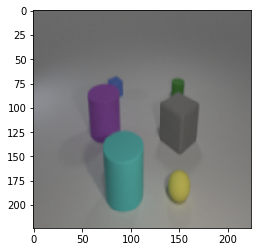

In [19]:
x=next(it)
plt.imshow(x['source'][4])

0.93818414
0.07314482


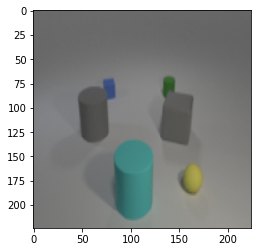

In [20]:

print(np.max(x['target']))
print(np.min(x['target']))
plt.imshow(x['target'][4])

In [21]:
x['mod_str'][4]

<tf.Tensor: shape=(), dtype=string, numpy=b'make large purple object gray'>

In [22]:
import tensorflow_hub as hub
model = tf.keras.Sequential()

class ResnetIdentityBlock(tf.keras.Model):
      def __init__(self):
        self.embed_dim=2048    
        super(ResnetIdentityBlock, self).__init__(name='')
        #filters1, filters2, filters3 = filters
        self.imgm=hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
               trainable=False, arguments=dict(batch_norm_momentum=0.997))
        self.bn2a  = tf.keras.layers.BatchNormalization()
        #self.linear = tf.keras.layers.Dense(embed_dim, input_shape=(2048,))
    

      def call(self, input_tensor, training=False):
        x = self.imgm(input_tensor)
        x = self.bn2a(x, training=False)
        return x


class NormalizationLayer(tf.keras.Model):
  """Class for normalization layer."""
  def __init__(self, normalize_scale=4.0, learn_scale=True):
    super(NormalizationLayer, self).__init__()
    self.norm_s = float(normalize_scale)
    if learn_scale:
        self.norm_s = tf.Variable(self.norm_s, name='Normweights')

  def call(self, x):

    features = (self.norm_s * tf.math.l2_normalize(    x, axis=1, epsilon=1e-12 ))

    #features = self.norm_s * x / torch.norm(x, dim=1, keepdim=True).expand_as(x)
    return features


# class MyDenseLayer(tf.keras.layers.Layer):
#   def __init__(self, num_outputs):
#     super(MyDenseLayer, self).__init__()
#     self.num_outputs = num_outputs

#   def build(self, input_shape):
#     self.kernel = self.add_weight("kernel",
#                                     shape=[int(input_shape[-1]),
#                                            self.num_outputs])

#   def call(self, input):
#     return tf.matmul(input, self.kernel)

my_seq = tf.keras.Sequential([ResnetIdentityBlock(),NormalizationLayer()])
my_seq2 = tf.keras.Sequential([ResnetIdentityBlock()])

#layer = MyDenseLayer(10)

In [23]:
y=my_seq(x['target']) 
y2=my_seq2(x['target']) 
print(y2.shape)
print(y.shape)

(32, 2048)
(32, 2048)


In [24]:
#print(y.shape)
print(np.min(y2),np.max(y2))
print(np.min(y),np.max(y))
#tf.Variable([1.0, 10.0, 1.0, 1.0], tf.float32)

0.0 21.88695
0.0 2.1916814


In [25]:
import string
import numpy as np
from tensorflow.keras import layers


class SimpleVocab(object):

  def __init__(self):
    super(SimpleVocab, self).__init__()
    self.word2id = {}
    self.wordcount = {}
    self.word2id['<UNK>'] = 0
    self.wordcount['<UNK>'] = 9e9

  def tokenize_text(self, text):
    text = text
    tokens = str(text).lower().translate(str.maketrans('','',string.punctuation)).strip().split()
    return tokens

  def add_text_to_vocab(self, text):
    tokens = self.tokenize_text(text)
    
    for token in tokens:
      if token not in self.word2id:
        self.word2id[token] = len(self.word2id)
        self.wordcount[token] = 0
      self.wordcount[token] += 1

    

  def threshold_rare_words(self, wordcount_threshold=5):
    for w in self.word2id:
      if self.wordcount[w] < wordcount_threshold:
        self.word2id[w] = 0

  def encode_text(self, text):
    tokens = self.tokenize_text(text)
    x = [self.word2id.get(t, 0) for t in tokens]
    return x

  def get_size(self):
    return len(self.word2id)


class TextLSTMModel(tf.keras.Model):

  def __init__(self,
               texts_to_build_vocab,
               word_embed_dim=1028,
               lstm_hidden_dim=1028):

    super(TextLSTMModel, self).__init__()

    self.vocab = SimpleVocab()
    for text in texts_to_build_vocab:
      self.vocab.add_text_to_vocab(text)
    vocab_size = self.vocab.get_size()

    self.word_embed_dim = word_embed_dim
    self.lstm_hidden_dim = lstm_hidden_dim
    #self.embedding_layer = torch.nn.Embedding(vocab_size, word_embed_dim)
    self.embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=word_embed_dim)
    #GRU_implementaiontf.keras.layers.RNN( 
    self.gru=tf.keras.layers.GRU(lstm_hidden_dim) 
    #self.gru = layers.GRU(word_embed_dim, lstm_hidden_dim)
    
    # self.lstm = torch.nn.LSTM(word_embed_dim, lstm_hidden_dim)
    #     self.fc_output = torch.nn.Sequential(
    #         torch.nn.Dropout(p=0.1),
    #         torch.nn.Linear(lstm_hidden_dim, lstm_hidden_dim),
    #     )
    #self.fc_output = tf.keras.Sequential([tf.keras.layers.Dropout(.1),
                                         # tf.keras.layers.Dense(lstm_hidden_dim,lstm_hidden_dim)])
    self.fc_output = tf.keras.Sequential([tf.keras.layers.Dropout(.1), 
                                          tf.keras.layers.Dense(lstm_hidden_dim, input_shape=(lstm_hidden_dim,))])

  def call(self, x):

    # to tensor
#     lengths = [len(t) for t in texts]
#     itexts = tf.tensor(tf.zeros([np.max(lengths), len(texts)]))
#     #itexts = torch.zeros((np.max(lengths), len(texts))).long()
#     for i in range(len(texts)):
#       itexts[:lengths[i], i] = tf.Variable(texts[i])

    # embed words
#     if torch.cuda.is_available():
#       itexts = torch.autograd.Variable(itexts).cuda()
    x = [self.vocab.encode_text(text) for text in x]
    lengths = [len(t) for t in x]
    itexts = np.zeros((len(x),np.max(lengths)))
    for i in range(len(x)):
        #print(i)
        itexts[ i,:lengths[i]]=(x[i])
        #print("x",x[i])
        #print(itexts)
    
    #itexts=self.vocab.encode_text(texts)
    #print(itexts)
    
    etexts = self.embedding_layer(itexts)

    # lstm
    lstm_output = self.forward_lstm_(etexts)
    
    # get last output (using length)
#     text_features = []
#     for i in range(len(x)):
#       text_features.append(lstm_output[lengths[i] - 1, i, :])
    # output
    #text_features = torch.stack(text_features)
    text_features = self.fc_output(lstm_output)
    return text_features

  def forward_lstm_(self, etexts):
    batch_size = etexts.shape[1]
    
    #GRU implemention
    #first_hidden = (torch.zeros(1, batch_size, self.lstm_hidden_dim))
    #first_hidden = (first_hidden[0].cuda(), first_hidden[1].cuda())
#     if torch.cuda.is_available(): 
#       first_hidden = (first_hidden.cuda())
#     else :
#       first_hidden = (first_hidden)

    lstm_output = self.gru(etexts)
    # print("GRU CALLED")

    return lstm_output

In [26]:
x=next(it)
text=x['mod_str']

In [27]:
texts=[t for t in xx.get_all_texts()]

In [28]:
embed_dim=1280
text_model = TextLSTMModel(
                    texts_to_build_vocab=texts,
                    word_embed_dim=embed_dim,
                    lstm_hidden_dim=embed_dim)

In [29]:
text_model(text)

<tf.Tensor: shape=(32, 1280), dtype=float32, numpy=
array([[-0.0027497 ,  0.01996926,  0.03127627, ..., -0.02119767,
         0.01139197,  0.02637821],
       [-0.0082362 ,  0.02282355,  0.03349533, ..., -0.01982735,
         0.0121906 ,  0.02370686],
       [-0.00267662,  0.01963019,  0.0362697 , ..., -0.02234709,
         0.01390666,  0.03012392],
       ...,
       [-0.00442451,  0.01533274,  0.02883581, ..., -0.01620508,
         0.00500441,  0.02572719],
       [-0.00598551,  0.01965377,  0.03145843, ..., -0.02283865,
         0.01391649,  0.02656338],
       [-0.00526672,  0.01747405,  0.03112719, ..., -0.02331364,
         0.01334436,  0.02593824]], dtype=float32)>

In [30]:
text_model.summary()

Model: "text_lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  35840     
_________________________________________________________________
gru (GRU)                    multiple                  9838080   
_________________________________________________________________
sequential_3 (Sequential)    multiple                  1639680   
Total params: 11,513,600
Trainable params: 11,513,600
Non-trainable params: 0
_________________________________________________________________


In [31]:
text_feat=text_model(text)

In [32]:
text_feat.shape

TensorShape([32, 1280])

In [33]:
# class Concat(tf.keras.Model):
#   """Concatenation model."""

#   def __init__(self, texts, embed_dim):
#     super(Concat, self).__init__(texts, embed_dim)    
    
#     class Composer(tf.keras.Model):
#         """Inner composer class."""
#         def __init__(self):
#                 super(Composer, self).__init__()

#                 self.b1= tf.keras.layers.BatchNormalization(axis=-1)
#                 self.D1= tf.keras.layers.Dense(2 * embed_dim, input_shape=(2 * embed_dim,))
#                 self.b2= tf.keras.layers.BatchNormalization(axis=-1)
#                 self.Drop= tf.keras.layers.Dropout(0.1)
#                 self.D2=   tf.keras.layers.Dense(2 * embed_dim, input_shape=(2 * embed_dim,))

#         def forward(self, x):
#                 f = tf.concat(c, axis=1, name='concat')
#                 f = self.b1(f)
#                 f = tf.nn.relu(f)
#                 f = self.D1(f)
#                 f = self.b2(f)
#                 f = tf.nn.relu(f)
#                 f = self.Drop(f)
#                 f = self.D2(f)
#                 return f

#     self.composer = Composer()

#     def compose_img_text(self, imgs, texts):
#             img_features = self.extract_img_feature(imgs)
#             text_features = self.extract_text_feature(texts)
#             return self.compose_img_text_features(img_features, text_features)

#     def compose_img_text_features(self, img_features, text_features):
#             return self.composer((img_features, text_features))


In [34]:
# class Composer(tf.keras.Model):
#         """Inner composer class."""
#         def __init__(self):
#                 super(Composer, self).__init__()

#                 self.b1= tf.keras.layers.BatchNormalization(axis=-1)
#                 self.D1= tf.keras.layers.Dense(2 * embed_dim, input_shape=(2 * embed_dim,))
#                 self.b2= tf.keras.layers.BatchNormalization(axis=-1)
#                 self.Drop= tf.keras.layers.Dropout(0.1)
#                 self.D2=   tf.keras.layers.Dense( embed_dim, input_shape=(2 * embed_dim,))

#         def call(self, x,y):
#                 f = tf.concat([x,y], axis=1, name='concat')

#                 f = self.b1(f)
#                 f = tf.nn.relu(f)
#                 f = self.D1(f)
#                 f = self.b2(f)
#                 f = tf.nn.relu(f)
#                 f = self.Drop(f)
#                 f = self.D2(f)
#                 return f

In [35]:
IMG_SHAPE = (224, 224, 3)

In [36]:
base_model =tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=IMG_SHAPE
)

In [37]:
base_model.trainable = False

In [38]:
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
base_model.trainable = False
img_extractor = tf.keras.Sequential([
  base_model,
  tf.keras.layers.BatchNormalization()
])

In [39]:
img_extractor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 2048)        8192      
Total params: 23,595,904
Trainable params: 4,096
Non-trainable params: 23,591,808
_________________________________________________________________


In [40]:
img_extractor.trainable_variables

[<tf.Variable 'batch_normalization_2/gamma:0' shape=(2048,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization_2/beta:0' shape=(2048,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>]

In [67]:
class ConCatModule(tf.keras.Model):

  def __init__(self):
    super(ConCatModule, self).__init__()

  def call(self, x):
    x = tf.concat(x, axis=1)
    return x


class TIRG(tf.keras.Model):
  def __init__(self, texts, embed_dim):
        super(TIRG, self).__init__().__init__(name='')

        self.a = tf.Variable(([0.1, 0.2, 0.7, 1.0]))
        self.gated_feature_composer = tf.keras.models.Sequential([
                        ConCatModule(), 
                        tf.keras.layers.BatchNormalization(axis=-1), 
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Dense(embed_dim, input_shape=(2 * embed_dim,)),
                        ])

        self.res_info_composer = tf.keras.models.Sequential([
                        ConCatModule(), 
                        tf.keras.layers.BatchNormalization(axis=-1), 
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Dense(2 * embed_dim, input_shape=(2 * embed_dim,)),
                        tf.keras.layers.Activation('relu'),
                        tf.keras.layers.Activation('softmax'),
                        tf.keras.layers.Dense( embed_dim, input_shape=(2 * embed_dim,))
                        ])         

                        
#         self.text_model = tf.keras.Sequential(TextLSTMModel(texts_to_build_vocab=texts,word_embed_dim=embed_dim,
#                         lstm_hidden_dim=embed_dim)   ) 

#         self.Img_feature = tf.keras.Sequential([ResnetIdentityBlock()])

#   def extract_img(self,img):
#         return self.Img_feature(img)

  def call(self, img_features, text_features):   
        
    
    f1 = self.gated_feature_composer((img_features, text_features))
    f2 = self.res_info_composer((img_features, text_features))
    f = tf.keras.activations.sigmoid(f1) * img_features * self.a[0] + f2 * self.a[1]+img_features * self.a[2] 
    return f


In [42]:
# compose=Composer()
# def compose_img_text(imgs, texts):
#     img_features=my_seq2(imgs)
#     text_features=text_model.forward_encoded_texts(texts)
    
#     return compose(img_features, text_features)

# # compose=Composer()
# # composite=compose(y,text_feat)

In [43]:
# TIRGmodel.summary()

In [44]:
# it = iter(image_dataset)
# x=next(it)
# com=TIRGmodel(x['source'],x['mod_str'])
# target=my_seq2(x['target'])
# source=my_seq2(x['source'])
# print(target.shape)

In [45]:
# it = iter(image_dataset)
# x=next(it)
# com=compose_img_text(x['target'],x['mod_str'])
# target=my_seq2(x['target'])
# source=my_seq2(x['source'])
# print(target.shape)

In [46]:
# np.sum(target-source)

In [47]:

class ConCatModule(torch.nn.Module):

  def __init__(self):
    super(ConCatModule, self).__init__()

  def forward(self, x):
    x = torch.cat(x, dim=1)
    return x




class ImgTextCompositionBase(torch.nn.Module):
  """Base class for image + text composition."""

  def __init__(self):
    super(ImgTextCompositionBase, self).__init__()
    self.normalization_layer = torch_functions.NormalizationLayer(
        normalize_scale=4.0, learn_scale=True)
    self.soft_triplet_loss = torch_functions.TripletLoss()

  def extract_img_feature(self, imgs):
    raise NotImplementedError

  def extract_text_feature(self, texts):
    raise NotImplementedError

  def compose_img_text(self, imgs, texts):
    raise NotImplementedError

  def compute_loss(self,
                   imgs_query,
                   modification_texts,
                   imgs_target,
                   soft_triplet_loss=True):
   
    mod_img1 = self.compose_img_text(imgs_query, modification_texts)
    mod_img1 = self.normalization_layer(mod_img1)
    
    img2 = self.extract_img_feature(imgs_target)
    img2 = self.normalization_layer(img2)
    
    assert (mod_img1.shape[0] == img2.shape[0] and
            mod_img1.shape[1] == img2.shape[1])
    if soft_triplet_loss:
      
      return self.compute_soft_triplet_loss_(mod_img1, img2)
    else:
      return self.compute_batch_based_classification_loss_(mod_img1, img2)


  def compute_soft_triplet_loss_(self, mod_img1, img2):
    triplets = []
    labels = list(range(mod_img1.shape[0])) + list(range(img2.shape[0]))
    for i in range(len(labels)):
      triplets_i = []
      for j in range(len(labels)):
        if labels[i] == labels[j] and i != j:
          for k in range(len(labels)):
            if labels[i] != labels[k]:
              triplets_i.append([i, j, k])
      np.random.shuffle(triplets_i)
      triplets += triplets_i[:3]
    assert (triplets and len(triplets) < 2000)
    #print(self.soft_triplet_loss(torch.cat([mod_img1, img2]), triplets))
    return self.soft_triplet_loss(torch.cat([mod_img1, img2]), triplets)

  def compute_batch_based_classification_loss_(self, mod_img1, img2):
    x = torch.mm(mod_img1, img2.transpose(0, 1))
    labels = torch.tensor(range(x.shape[0])).long()
    labels = torch.autograd.Variable(labels).cuda()
    return F.cross_entropy(x, labels)


class ImgEncoderTextEncoderBase(ImgTextCompositionBase):
  """Base class for image and text encoder."""

  def __init__(self, texts, embed_dim):
    super(ImgEncoderTextEncoderBase, self).__init__()

    # img model
    img_model = torchvision.models.resnet18(pretrained=True)

    class GlobalAvgPool2d(torch.nn.Module):

      def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1, 1))

    img_model.avgpool = GlobalAvgPool2d()
    img_model.fc = torch.nn.Sequential(torch.nn.Linear(512, embed_dim))
    self.img_model = img_model

    # text model
    self.text_model = text_model.TextLSTMModel(
        texts_to_build_vocab=texts,
        word_embed_dim=embed_dim,
        lstm_hidden_dim=embed_dim)

  def extract_img_feature(self, imgs):
    return self.img_model(imgs)

  def extract_text_feature(self, texts):
    return self.text_model(texts)


class TIRGRevGrad(ImgEncoderTextEncoderBase):
    def __init__(self, texts, embed_dim):
        super().__init__(texts, embed_dim)
        # self.feature_extractor = nn.Sequential(      
        # )
        self.num_cnn_features = embed_dim
        self.normalization_layer = torch_functions.NormalizationLayer(
            normalize_scale=4.0, learn_scale=True)
        self.soft_triplet_loss = torch_functions.TripletLoss()
        
        self.a = torch.nn.Parameter(torch.tensor([1.0, 10.0, 1.0, 1.0]))

        self.gated_feature_composer = torch.nn.Sequential(
             ConCatModule(), torch.nn.BatchNorm1d(2 * embed_dim),
             torch.nn.ReLU(),torch.nn.Linear(2 * embed_dim, embed_dim)
        )

        img_model = torchvision.models.resnet18(pretrained=True)
        class GlobalAvgPool2d(torch.nn.Module):
           def forward(self, x):
              return F.adaptive_avg_pool2d(x, (1, 1))
        img_model.avgpool = GlobalAvgPool2d()
        img_model.fc = torch.nn.Sequential(torch.nn.Linear(512, embed_dim))
        self.img_model = img_model

        # text model
        self.text_model = text_model.TextLSTMModel(
                    texts_to_build_vocab=texts,
                    word_embed_dim=embed_dim,
                    lstm_hidden_dim=embed_dim)
        
        self.res_info_composer = torch.nn.Sequential(
            ConCatModule(), torch.nn.BatchNorm1d(2 * embed_dim),
            torch.nn.ReLU(), torch.nn.Linear(2 * embed_dim, 2 * embed_dim),
            torch.nn.ReLU(), torch.nn.Linear(2 * embed_dim, embed_dim)
        )

        self.domain_classifier = torch.nn.Sequential(
            torch.nn.Linear(self.num_cnn_features, 100),
            torch.nn.BatchNorm1d(100), torch.nn.ReLU(True),
            torch.nn.Linear(100, 2),
            torch.nn.LogSoftmax(dim=1),)

    def compute_loss(self,imgs_query,modification_texts,imgs_target,soft_triplet_loss=True):
            mod_img1 = self.compose_img_text(imgs_query, modification_texts)
            mod_img1 = self.normalization_layer(mod_img1)
            img2 = self.extract_img_feature(imgs_target)
            img2 = self.normalization_layer(img2)
            assert (mod_img1.shape[0] == img2.shape[0] and
                    mod_img1.shape[1] == img2.shape[1])
            return self.compute_soft_triplet_loss_(mod_img1, img2)

    def compute_soft_triplet_loss_(self, mod_img1, img2):
            triplets = []
            labels = list(range(mod_img1.shape[0])) + list(range(img2.shape[0]))
            for i in range(len(labels)):
              triplets_i = []
              for j in range(len(labels)):
                if labels[i] == labels[j] and i != j:
                  for k in range(len(labels)):
                    if labels[i] != labels[k]:
                      triplets_i.append([i, j, k])
              np.random.shuffle(triplets_i)
              triplets += triplets_i[:3]
            assert (triplets and len(triplets) < 2000)
            return self.soft_triplet_loss(torch.cat([mod_img1, img2]), triplets)


    def compose_img_text(self, imgs, texts):
        img_features = self.extract_img_feature(imgs)
        text_features = self.extract_text_feature(texts)
        return self.compose_img_text_features(img_features, text_features)

    def compose_img_text_features(self, img_features, text_features):
        f1 = self.gated_feature_composer((img_features, text_features))
        f2 = self.res_info_composer((img_features, text_features))
        f = torch.sigmoid(f1) * img_features * self.a[0] + f2 * self.a[1]
        return f

    def extract_img_feature(self, imgs):
             return self.img_model(imgs)

    def extract_text_feature(self, texts):
             return self.text_model(texts)          
            
    def forward(self, imgs_query, modification_texts,img2, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        # x = x.expand(x.data.shape[0], 3, image_size, image_size)

        loss = self.compute_loss(imgs_query, modification_texts,img2, soft_triplet_loss=True)
        features= self.compose_img_text(imgs_query, modification_texts)
        #features = features.view(-1, self.num_cnn_features)
        #print(features.shape)
        features_grl = GradientReversalFn.apply(features, grl_lambda)
        # class_pred = self.class_classifier(features)        # classify on regular features
        domain_pred = self.domain_classifier(features_grl)  # classify on features after GRL
        return domain_pred , loss


In [48]:
model = img_text_composition_models.TIRGRevGrad(texts, embed_dim=opt.embed_dim)

In [49]:
model.compute_loss(torch.from_numpy(x['source'].numpy()).permute(0,3,1,2),
                   [str(t) for t in x['mod_str']],x['target'],soft_triplet_loss=True)

["tf.Tensor(b'make top-center small object red', shape=(), dtype=string)", "tf.Tensor(b'make middle-right gray rectangle blue', shape=(), dtype=string)", "tf.Tensor(b'make middle-right brown circle yellow', shape=(), dtype=string)", "tf.Tensor(b'make top-right blue object red', shape=(), dtype=string)", "tf.Tensor(b'add yellow circle to bottom-right', shape=(), dtype=string)", "tf.Tensor(b'add small yellow triangle to middle-left', shape=(), dtype=string)", "tf.Tensor(b'make bottom-left large purple object blue', shape=(), dtype=string)", "tf.Tensor(b'make middle-right rectangle large', shape=(), dtype=string)", "tf.Tensor(b'remove middle-right small green object', shape=(), dtype=string)", "tf.Tensor(b'add green rectangle to top-right', shape=(), dtype=string)", "tf.Tensor(b'make middle-left large brown object red', shape=(), dtype=string)", "tf.Tensor(b'make top-center circle large', shape=(), dtype=string)", "tf.Tensor(b'add large green rectangle to bottom-right', shape=(), dtype=st

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select

In [50]:
def compute_batch_based_classification_loss_(mod_img1, img2):
    x = torch.matmul(torch.tensor(mod_img1), torch.tensor(img2.transpose(1, 0)))
    labels = torch.tensor(range(x.shape[0])).long()
    labels = torch.autograd.Variable(labels)
    return torch.nn.functional.cross_entropy(x, labels).numpy()

In [51]:
def loss2(mod_img1, img2):
    x=tf.matmul(mod_img1, tf.transpose(img2, perm=[ 1, 0]))
    labels = (range(x.shape[0]))
    return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, x))

In [52]:
text_features=text_model(x['mod_str'])
imgS=img_extractor(x['source'])
imgT=img_extractor(x['target'])
#                 print(text_features.shape,imgS.shape,imgT.shape)
C_feature=TIRGmodel(text_features, imgS)
loss=compute_soft_triplet_loss_(C_feature,imgT)

NameError: name 'TIRGmodel' is not defined

In [ ]:
print(compute_batch_based_classification_loss_(C_feature.numpy(), imgT.numpy()))
print(compute_batch_based_classification_loss_(imgS.numpy(), imgT.numpy()))
print(compute_batch_based_classification_loss_(imgT.numpy(), imgT.numpy()))

In [ ]:
print(loss2(C_feature.numpy(), imgT.numpy()))
print(loss2(imgS.numpy(), imgT.numpy()))
print(loss2(imgT.numpy(), imgT.numpy()))

In [ ]:
# my_seq2(x['source'])-my_seq2(x['target'])

In [ ]:
def compute_soft_triplet_loss_( mod_img1, img2):
    triplets = []
    labels = list(range(mod_img1.shape[0])) + list(range(img2.shape[0]))
    for i in range(len(labels)):
      triplets_i = []
      for j in range(len(labels)):
        if labels[i] == labels[j] and i != j:
          for k in range(len(labels)):
            if labels[i] != labels[k]:
              triplets_i.append([i, j, k])
      np.random.shuffle(triplets_i)
      triplets += triplets_i[:3]
    assert (triplets and len(triplets) < 2000)
    #print(self.soft_triplet_loss(torch.cat([mod_img1, img2]), triplets))
    soft_triplet_loss=TripletLoss()
    return soft_triplet_loss(tf.concat([mod_img1, img2], axis= 0, name='concat'), triplets)


In [ ]:
def pairwise_distances(x, y=None):
  """
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between
    x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    source:
    https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065/2
    """
  x_norm1 = torch.from_numpy((x**2).numpy()).sum(1).view(-1, 1)
  #print(x_norm1)
  x_norm = tf.reshape(tf.reduce_sum(x**2,1), [-1, 1])
  #print(x_norm1.numpy()-x_norm)
  if y is not None:
        y_t = tf.transpose(y, perm=[ 1, 0])
        y_norm = tf.reshape(tf.reduce_sum(y**2,1), [-1, 1])
        #print("y",y_t.shape)
  else:
    y_t = tf.transpose(x,  perm=[1, 0]) 
    y_norm = tf.reshape(x_norm,[1,-1])
    
    y_t1 = torch.transpose(torch.from_numpy(x.numpy()), 0, 1)
    y_norm1 =( x_norm1).view(1, -1)
    #print(np.sum(y_norm-y_norm1.numpy()))

  dist = x_norm + y_norm 
  dist = dist - 2.0 * tf.matmul(x, y_t)
    
  dist1= x_norm1 + y_norm1 - 2.0 * torch.mm(torch.from_numpy(x.numpy()), y_t1)
  #print("torch clam",torch.clamp(dist1, 0.0, np.inf)) 
  #print("TENSORFLO",tf.clip_by_value(dist, clip_value_min= 0.0, clip_value_max=1000) )
  
  # Ensure diagonal is zero if x=y
  # if y is None:
  #     dist = dist - torch.diag(dist.diag)
  return dist1
class TripletLoss(tf.keras.Model):
  """Class for the triplet loss."""
  def __init__(self, pre_layer=None):
    super(TripletLoss, self).__init__()
    self.pre_layer = pre_layer

  def call(self, x, triplets):
    
    if self.pre_layer is not None:
      x = self.pre_layer(x)
    
    
    #loss = MyTripletLossFunc(triplets)(x)

    #modifications
    self.triplets = triplets
    #print(triplets)
    self.triplet_count = len(triplets)
    #self.distances = pairwise_distances(x).detach().cpu().numpy()
    self.distances = pairwise_distances(x)
    #print(np.max(self.distances) )
    loss = 0.0
    triplet_count = 0.0
    correct_count = 0.0
    max_loss=0
    for i, j, k in self.triplets:
      w = 1.0
      triplet_count += w
      loss += w * np.log(1 +np.exp(self.distances[i, j] - self.distances[i, k]))
#       if (np.log(1 +np.exp(self.distances[i, j] - self.distances[i, k]))>10000):
#             #print(self.distances[i, j] , self.distances[i, k],"NEXT")
   
      if self.distances[i, j] < self.distances[i, k]:
        correct_count += 1
    #print(triplet_count)
    loss /= triplet_count
    #print(loss)
    return loss


In [ ]:
text_features=text_model(x['mod_str'])
imgS=img_extractor(x['source'])
imgT=img_extractor(x['target'])
#                 print(text_features.shape,imgS.shape,imgT.shape)
C_feature=TIRGmodel(text_features, imgS)
print(compute_soft_triplet_loss_(C_feature,imgT))
print(compute_soft_triplet_loss_(imgT,imgS))
print(compute_soft_triplet_loss_(imgT,imgT))


In [ ]:
np.mean(imgS-imgT)

In [54]:
loss_plot = []

In [55]:
# img_model = ResnetIdentityBlock()
# text_model = TextLSTMModel(
#                     texts_to_build_vocab=texts,
#                     word_embed_dim=embed_dim,
#                     lstm_hidden_dim=embed_dim)
# compose=Composer()

In [56]:
# t_img=my_seq2(x['target'])
# print(s_img.shape)
# s_img=my_seq2(x['source'])
# print(t_img.shape)
# text_features=text_model.forward_encoded_texts(x['mod_str'])
# C_feature=compose(s_img, text_features)


# compute_soft_triplet_loss_(C_feature,s_img)
#loss2(C_feature,t_img)

In [73]:
text_model = TextLSTMModel(
                    texts_to_build_vocab=texts,
                    word_embed_dim=embed_dim,
                    lstm_hidden_dim=embed_dim)

In [74]:
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
base_model.trainable = True


In [75]:
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [76]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [77]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [78]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

Number of layers in the base model:  155


In [79]:
img_extractor = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(data_format=None),
  tf.keras.layers.BatchNormalization()
])
img_extractor.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1280)              5120      
Total params: 2,263,104
Trainable params: 2,226,432
Non-trainable params: 36,672
_________________________________________________________________


In [80]:
TIRGmodel=TIRG(texts,1280)

In [81]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.00001)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
optimizer3 = tf.keras.optimizers.Adam(learning_rate=0.0001)
def train_step(x):
        loss = 0
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2, tf.GradientTape() as tape3:
#                 print(x['source'].shape,x['target'].shape)
                text_features=text_model(x['mod_str'])
                imgS=img_extractor(x['source'])
                imgT=img_extractor(x['target'])
                #print(text_features.shape,imgS.shape,imgT.shape)
                C_feature=TIRGmodel(text_features, imgS)
                loss=loss2(C_feature,imgT)
                #loss=loss+loss2(imgT,imgT)
                #print(loss)

#         trainable_variables1 = img_extractor.trainable_variables 
#         trainable_variables2 = TIRGmodel.trainable_variables
#         trainable_variables3 = text_model.trainable_variables

        gradients_of_generator = tape1.gradient(loss,TIRGmodel.trainable_variables) 
        optimizer2.apply_gradients(zip(gradients_of_generator, TIRGmodel.trainable_variables))
        
        gradients_of_d = tape2.gradient(loss,text_model.trainable_variables) 
        optimizer3.apply_gradients(zip(gradients_of_d, text_model.trainable_variables))
        
        gradients_of_d = tape3.gradient(loss,img_extractor.trainable_variables) 
        optimizer1.apply_gradients(zip(gradients_of_d, img_extractor.trainable_variables))
        
        
    

        #optimizer1.apply_gradients(zip(D1, trainable_variables1))
        #optimizer2.apply_gradients(zip(D2, trainable_variables2))

        return loss

In [82]:
EPOCHS = 20
num_steps=19000
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    batchloss = 0
    print("Epoch",epoch,)
    for (batch, x) in enumerate(image_dataset):
        t_loss = train_step(x)
        batchloss+=t_loss
        total_loss += t_loss

        if batch % 100 == 0:
#             print(t_loss)
            print ('Epoch {} Batch {}'.format(
              epoch + 1, batch))
            print(batchloss)
            batchloss=0
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    if epoch%5==1:
        tests = []
        for name, dataset in [ ('test', testset)]:
            t = test(opt, TIRGmodel,img_extractor,text_model, dataset)
            tests += [(name + ' ' + metric_name, metric_value)
                      for metric_name, metric_value in t]
        for metric_name, metric_value in tests:
            print ('    ', metric_name, round(metric_value, 4))
            
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 0


ResourceExhaustedError: OOM when allocating tensor with shape[32,56,56,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:DepthwiseConv2dNative] name: sequential_12/mobilenetv2_1.00_224/block_1_depthwise/depthwise/

In [ ]:
EPOCHS = 20
num_steps=19000
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    batchloss = 0
    print("Epoch",epoch,)
    for (batch, x) in enumerate(image_dataset):
        t_loss = train_step(x)
        batchloss+=t_loss
        total_loss += t_loss

        if batch % 100 == 0:
#             print(t_loss)
            print ('Epoch {} Batch {}'.format(
              epoch + 1, batch))
            print(batchloss)
            batchloss=0
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    if epoch%5==1:
        tests = []
        for name, dataset in [ ('test', testset)]:
            t = test(opt, TIRGmodel,img_extractor,text_model, dataset)
            tests += [(name + ' ' + metric_name, metric_value)
                      for metric_name, metric_value in t]
        for metric_name, metric_value in tests:
            print ('    ', metric_name, round(metric_value, 4))
            
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:

plt.plot(loss_plot)

In [ ]:
loss_plot=[]

In [ ]:
TIRGmodel.save_weights('/home/alinsteinjose/alin/project/Image_text_retrival/Tensorflow_TIRG_model')
text_model.save_weights('/home/alinsteinjose/alin/project/Image_text_retrival/Tensorflow_TXT_model')
img_extractor.save_weights('/home/alinsteinjose/alin/project/Image_text_retrival/Tensorflow_IMG_model')


In [ ]:
# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')